#**Brain Tumor Detection**

#**ABSTRACT**

Aim of the notebook is to demonstrate an efficient deep learning technique for Brain Tumor Detection.

In this notebook we will be comparing the performance of Simple CNN with state-of-art CNN architechtures like ReSNet and VGGNet, to determine the best model for detecting the brain tumor. Here we will be comparing the 'accuracy' of each model to determine the most suitable model.

We have acheived an accuracy of 98.8% by using VGG16 Model.

#Importing neccesary libraries

In [2]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import Model, layers
from keras.optimizers import *
from tensorflow.python.keras.layers import BatchNormalization

**Loading the data set from Google drive**

This data set has images classified into two categories, Brain_Tumor and Haelthy

In [3]:
from google.colab import drive

drive.mount('/gdrive')

import zipfile

with zipfile.ZipFile('/gdrive/MyDrive/brain/Brain_Tumor_Data_Set.zip', 'r') as zip_ref:

    zip_ref.extractall('gdrive/MyDrive/')

Mounted at /gdrive


**Splitting the data**

Below, we are splitting the dataset into 'train'(training dataset) and 'val'(validation dataset) datasets.

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
#gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,zoom_range=(0.99,0.99),dtype=tf.float32,preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

gen = ImageDataGenerator(validation_split = 0.2,dtype=tf.float32,preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Brain_Tumor_Data_Set',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset = "training")

val = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Brain_Tumor_Data_Set',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset = "validation")


Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [ ]:
classes = val.class_indices
print (classes)

{'Brain_Tumor': 0, 'Healthy': 1}


In [ ]:
classes1 = train.class_indices
print (classes1)

{'Brain_Tumor': 0, 'Healthy': 1}


In [ ]:
print (classes)

{'Brain_Tumor': 0, 'Healthy': 1}


**Visualizing training and Validation datasets**

In [ ]:
def show_brain_images(image_gen):
    test_dict = val.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

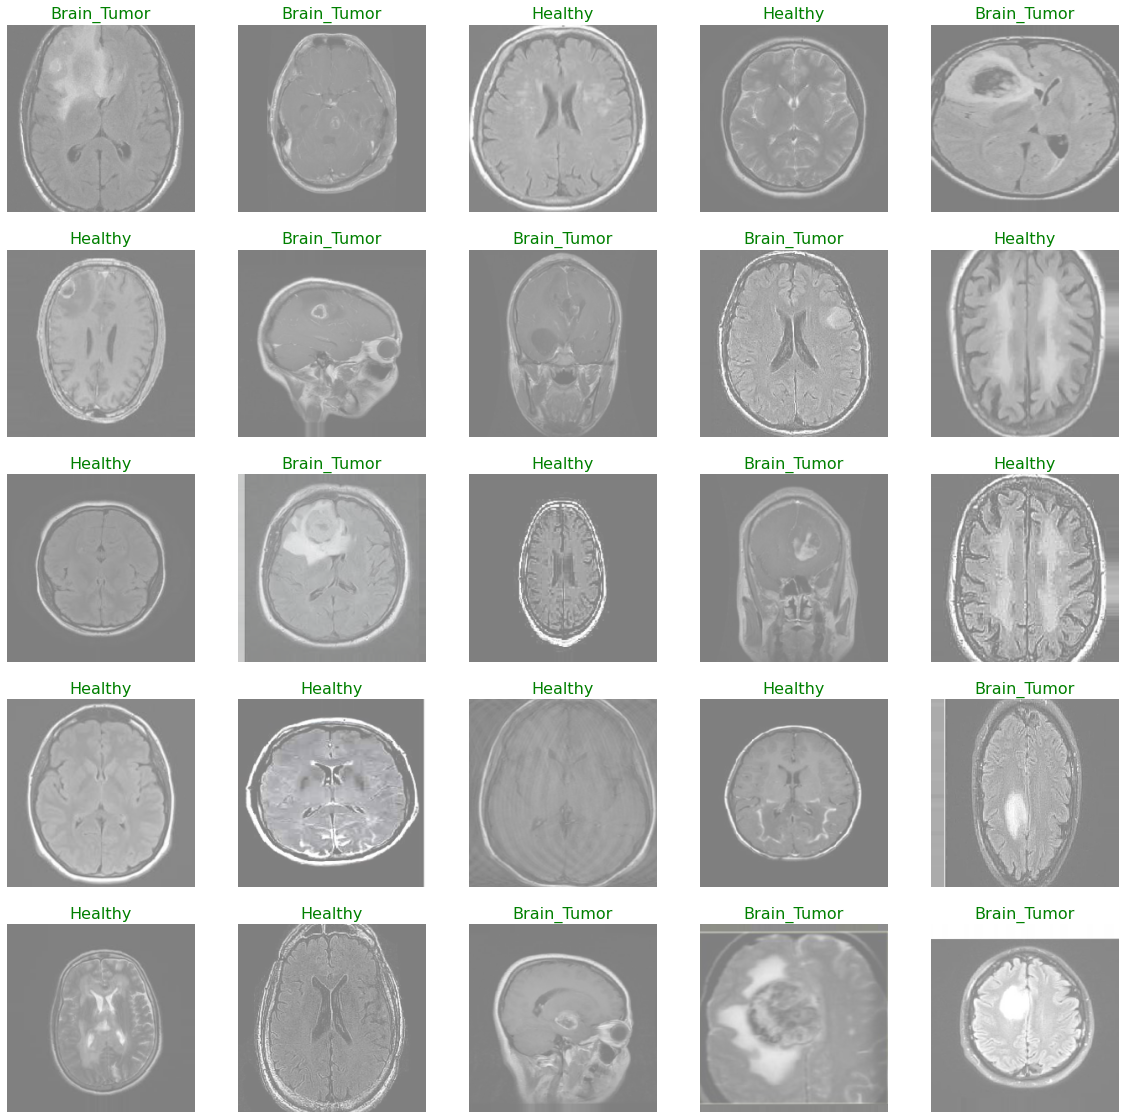

In [ ]:
show_brain_images(train)

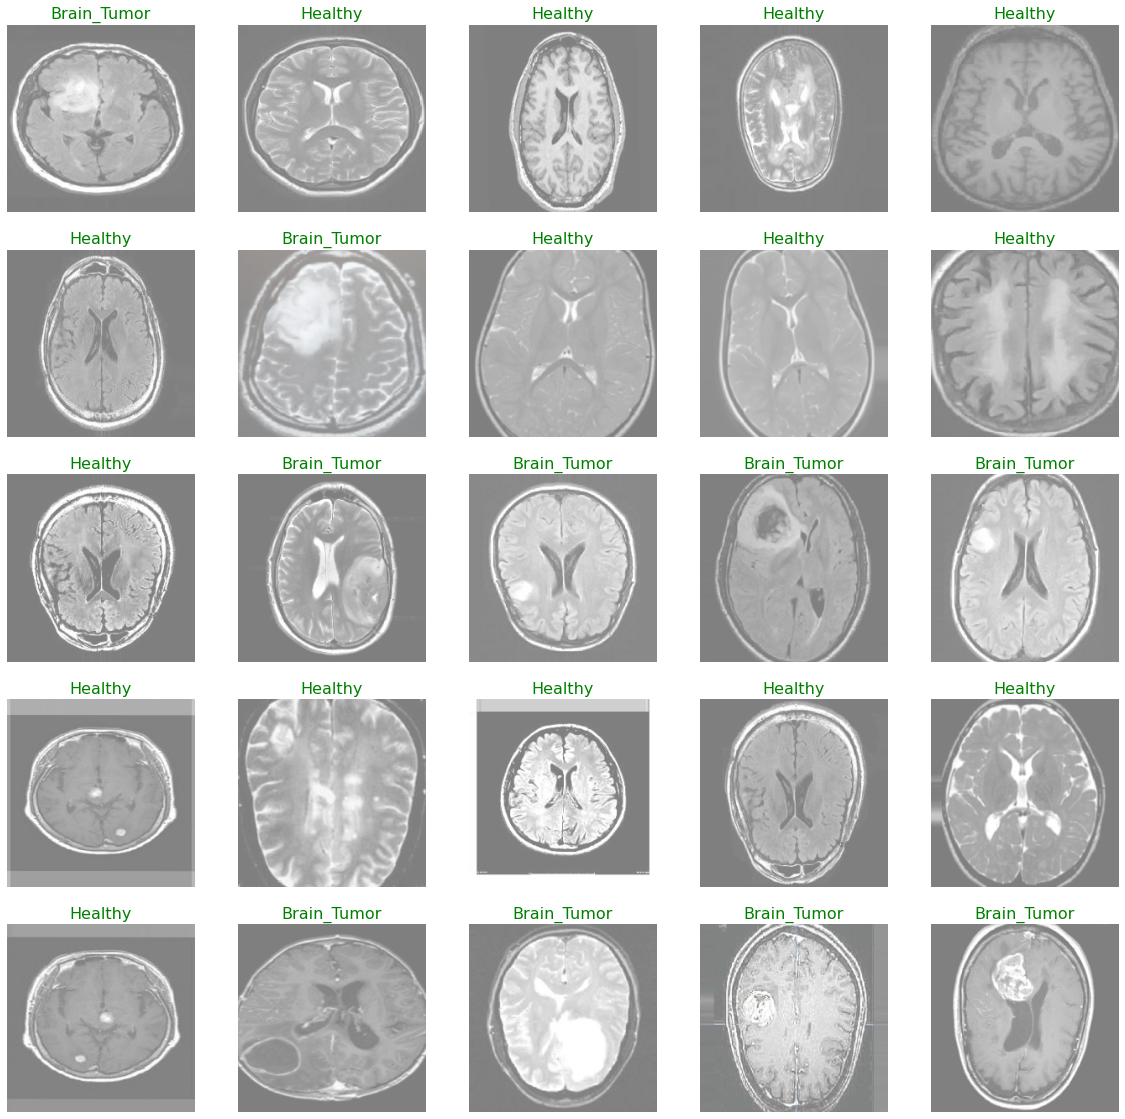

In [ ]:
show_brain_images(val)

#**Implementing Simple CNN**

Firstly, we implement a simple CNN for detecting the brain tumors from the X-ray images. Through pre-processing, we have converted all the images into a similar size of 224 * 224 and split the data into trainng and validation datasets.We define a sequntial model with multiple layers, with an activation function **ReLU** to introduce non-linearity to the model and Sigmoid function in the output layer  to convert a classifier’s raw output values into probabilities.

Here are apply **binary_crossentropy** cost function to measure to the model and **Adam optimizer** to update network weights and reduce the losses. Later, we are fitting the model and measuring the accuracy. 

Lastly, we are visualizing the accuracy and loss curves.

We can infer the following from the accuracies and losses.
We have acheived an **accuracy of 86%** by using simple CNN. Analysing further, we can observe that the training accuracy and the validation accuracy are almost the same, hence there is no over-fitting. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 128)               51380352  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

Text(0, 0.5, 'Accuracy')

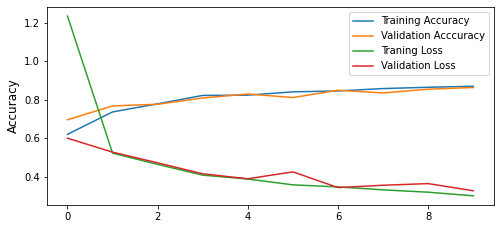

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import Model, layers
from keras.optimizers import *
from tensorflow.python.keras.layers import BatchNormalization
#Defining Sequential Model
model1 = Sequential()

model1.add(InputLayer(input_shape=(224,224,3)))
# defining conv-pool layer
model1.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="same",
               input_shape=(244,244,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

#adding flatten layer
model1.add(Flatten())

#adding dense layers with dropout
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(rate=0.3))
model1.add(Dense(64, activation="relu"))

#Output layer
model1.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary. Use Softmax for Mutliclass.

# tell the model what cost and optimization method to use
model1.compile(loss=keras.losses.binary_crossentropy, optimizer=tf.optimizers.Adam(),metrics=['accuracy'])
#Summary
model1.summary()
History1 = model1.fit(train, validation_data= val, epochs=10,verbose=1)

#plotting loss and accuracy
import matplotlib.pyplot as plt
acc = History1.history["accuracy"] # report of model
val_acc = History1.history["val_accuracy"] # history of validation data

loss = History1.history["loss"]        # Training loss
val_loss = History1.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns

plt.subplot(2,1,1)
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")
plt.plot(loss, label = "Traning Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.ylabel("Accuracy", fontsize=12)

#**Implementing VGG16**

Here, we are using the keras VGG16 model, imorting weights from '**imagenet**',a large database or dataset of over 14 million images where the machines are trained on a vast dataset of various images. Here we are setting **include_top=False** which means removing the final dense layers and allowing us to define the input size of the image. We need to add the final classification layers.

Here are apply **binary_crossentropy** cost function to measure to the model and **Adam optimizer** to update network weights and reduce the losses. Later, we are fitting the model and measuring the accuracy.

In the below model we can observe an **accuracy of 98.8%** in the 42nd epoch.

By visualizing the accuracy and loss curves, we can infer that the training accuracy and validation accuracy are almost similar which ensures there is no over-fitting in our model which means it is a good fit.

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
IMAGE_SIZE = [224, 224]
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=IMAGE_SIZE + [3]
)
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# don't train existing weights
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten,ReLU
NUM_CLASSES = 2
from keras import layers
from keras.optimizers import *

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14,865,218
Trainable params: 100,354
Non-trainable params: 14,764,864
______________________________________

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.998):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

Epoch 1/50
116/116 [==============================] - 64s 456ms/step - loss: 0.4169 - accuracy: 0.8457 - val_loss: 0.4065 - val_accuracy: 0.7878
Epoch 2/50
116/116 [==============================] - 50s 432ms/step - loss: 0.2529 - accuracy: 0.9161 - val_loss: 0.1878 - val_accuracy: 0.9293
Epoch 3/50
116/116 [==============================] - 50s 430ms/step - loss: 0.2175 - accuracy: 0.9247 - val_loss: 0.1521 - val_accuracy: 0.9499
Epoch 4/50
116/116 [==============================] - 50s 432ms/step - loss: 0.1795 - accuracy: 0.9451 - val_loss: 0.1391 - val_accuracy: 0.9456
Epoch 5/50
116/116 [==============================] - 50s 432ms/step - loss: 0.1703 - accuracy: 0.9427 - val_loss: 0.1149 - val_accuracy: 0.9663
Epoch 6/50
116/116 [==============================] - 50s 432ms/step - loss: 0.1698 - accuracy: 0.9432 - val_loss: 0.1514 - val_accuracy: 0.9576
Epoch 7/50
116/116 [==============================] - 50s 431ms/step - loss: 0.1720 - accuracy: 0.9489 - val_loss: 0.1280 - val_ac

Text(0, 0.5, 'Accuracy')

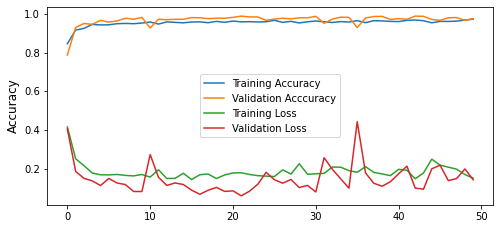

In [ ]:
callbacks = myCallback()
history = model.fit_generator(
    train,
    epochs=50,
    validation_data=val,
    callbacks=[callbacks]
)
acc = history.history["accuracy"] # report of model
val_acc = history.history["val_accuracy"] # history of validation data

loss = history.history["loss"]        # Training loss
val_loss = history.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns

plt.subplot(2,1,1)
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.ylabel("Accuracy", fontsize=12)

#**Implementing ResNet**

Here, we are using the keras ResNet50 model, imorting weights from 'imagenet',a large database or dataset of over 14 million images where the machines are trained on a vast dataset of various images. Here we are setting **include_top=False** which means removing the final dense layers and allowing us to define the input size of the image. We need to add the final classification layers.

We are also using other hyperparamets like **pooling='avg'**, Average Pooling is a pooling operation that calculates the average value for patches of a feature map, and uses it to create a downsampled (pooled) feature map.

Here are apply **binary_crossentropy** cost function to measure to the model and **SGD** optimizer to update network weights and reduce the losses. Later, we are fitting the model and measuring the accuracy.

In the below model we can observe an **accuracy of 59.09%**.

By visualizing the accuracy and loss curves, we can infer that model performed well on the training data but not as well on the validation data which means the model is overfitting in this case.

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_27 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 module_wrapper_8 (ModuleWra  (None, 512)              2048      
 pper)                                                           
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                     

Text(0, 0.5, 'Accuracy')

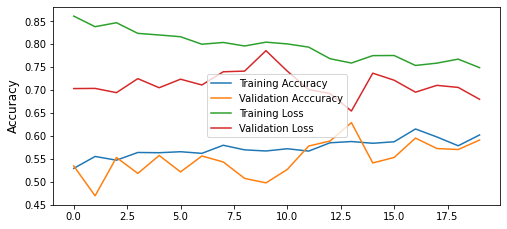

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import Model, layers
from keras.optimizers import *
from tensorflow.python.keras.layers import BatchNormalization

model3 = Sequential()
#vgg-16 , 80% accuracy with 100 epochs
# model.add(VGG16(input_shape=(224,224,3),pooling='avg',classes=1000,weights=vgg16_weights_path))
#resnet-50 , 87% accuracy with 100 epochs
model3.add(ResNet50(include_top=False,input_tensor=None,input_shape=(224,224,3),pooling='avg',weights="imagenet"))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(BatchNormalization())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(BatchNormalization())
model3.add(Dense(2, activation='sigmoid'))

model3.layers[0].trainable = False
model3.summary()
model3.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
#optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.0,nesterov=False, name="SGD")
#optimizer=tf.optimizers.Adam()
#optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9)

History3 = model3.fit(train,validation_data= val, epochs=20,verbose=1)

acc = History3.history["accuracy"] # report of model
val_acc = History3.history["val_accuracy"] # history of validation data

loss = History3.history["loss"]        # Training loss
val_loss = History3.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns

plt.subplot(2,1,1)
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.ylabel("Accuracy", fontsize=12)

#**Conclusion**

We have trained three models (CNN, ResNet and VGG16) to determine the best model to classify images in our dataset. By training our data on the above three models we can conclude that VGG16 with an accuracy of 98.8% is the best fit model for our dataset.